In [19]:
import numpy as np
import sys
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import matplotlib

In [2]:
def parse_index_file(filename):
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index


def load_data(dataset):
    # load the data: x, tx, allx, graph
    names = ['x', 'tx', 'allx', 'graph']
    objects = []
    for i in range(len(names)):
        with open("../gae/data/ind.{}.{}".format(dataset, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))
    x, tx, allx, graph = tuple(objects)
    test_idx_reorder = parse_index_file("../gae/data/ind.{}.test.index".format(dataset))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    return adj, features

def load_data_2(dataset): #Includes fixing isolated nodes for y
    
    # load the data: x, tx, allx, graph
    dataset = 'citeseer'
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open("../gae/data/ind.{}.{}".format(dataset, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))
    
    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file("../gae/data/ind.{}.test.index".format(dataset))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)

        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        ty_extended = sp.lil_matrix((len(test_idx_range_full), y.shape[1]))

        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        ty_extended[test_idx_range-min(test_idx_range), :] = ty

        tx = tx_extended
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    y        = sp.vstack((ally, ty)).tolil()
    
    features[test_idx_reorder, :] = features[test_idx_range, :]
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    
    return adj, features, ty, y
    
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)


In [37]:
features

(array([[   0,  184],
        [   0,  257],
        [   0,  362],
        ...,
        [3326, 3472],
        [3326, 3556],
        [3326, 3621]], dtype=int32),
 array([1., 1., 1., ..., 1., 1., 1.]),
 (3327, 3703))

In [3]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.input_data import load_data
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges


# Settings

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 16, 'Number of units in hidden layer 2.')
#flags.DEFINE_integer('hidden3', 2, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0., 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0., 'Dropout rate (1 - keep probability).')

flags.DEFINE_string('model', 'gcn_ae', 'Model string.')
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')
flags.DEFINE_integer('features', 1, 'Whether to use features (1) or not (0).')

flags.DEFINE_string('f', '', 'kernel')

#model_str = FLAGS.model
#dataset_str = FLAGS.dataset

model_str = 'gcn_vae'
dataset_str = 'citeseer'



# Load data
adj, features, ty, y = load_data_2(dataset_str)

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train

if FLAGS.features == 0:
    features = sp.identity(features.shape[0])  # featureless

# Some preprocessing
adj_norm = preprocess_graph(adj)

# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

num_nodes = adj.shape[0]

features = sparse_to_tuple(features.tocoo())
num_features = features[2][1]
features_nonzero = features[1].shape[0]

# Create model
model = None
if model_str == 'gcn_ae':
    model = GCNModelAE(placeholders, num_features, features_nonzero)
elif model_str == 'gcn_vae':
    model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero)

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

# Optimizer
with tf.name_scope('optimizer'):
    if model_str == 'gcn_ae':
        opt = OptimizerAE(preds=model.reconstructions,
                          labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                      validate_indices=False), [-1]),
                          pos_weight=pos_weight,
                          norm=norm)
    elif model_str == 'gcn_vae':
        opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm)

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

cost_val = []
acc_val = []


def get_roc_score(edges_pos, edges_neg, emb=None):
    
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score, emb, labels_all


cost_val = []
acc_val = []
val_roc_score = []

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

# Train model
for epoch in range(FLAGS.epochs):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    roc_curr, ap_curr, emb, labels_all = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

roc_score, ap_score, emb, labels_all = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))


/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
targets is deprecated, use labels instead

Epoch: 0001 train_loss= 1.74846 train_acc= 0.49665 val_roc= 0.67969 val_ap= 0.69701 time= 3.11017
Epoch: 0002 train_loss= 1.42160 train_acc= 0.43053 val_roc= 0.68419 val_ap= 0.71479 time= 0.63958
Epoch: 0003 train_loss= 1.23800 train_acc= 0.30977 val_roc= 0.70592 val_ap= 0.73647 time= 0.61458
Epoch: 0004 train_loss= 1.07967 train_acc= 0.32910 val_roc= 0.73581 val_ap= 0.75988 time= 0.53878
Epoch: 0005 train_loss= 0.93077 train_acc= 0.34203 val_roc= 0.77800 val_ap= 0.80135 time= 0.59736
Epoch: 0006 train_loss= 0.79480 train_acc= 0.38265 val_roc= 0.82357 val_ap= 0.83745 time= 0.48529
Epoch: 0007 train_loss= 0.70560 train_acc= 0.41406 val_roc= 0.83925 val_ap= 0.85159 time= 0.58998
Epoch: 0008 train_loss= 0.6454

Epoch: 0063 train_loss= 0.44684 train_acc= 0.52061 val_roc= 0.91778 val_ap= 0.92072 time= 0.57420
Epoch: 0064 train_loss= 0.44604 train_acc= 0.52048 val_roc= 0.91835 val_ap= 0.92128 time= 0.54476
Epoch: 0065 train_loss= 0.44594 train_acc= 0.52067 val_roc= 0.91914 val_ap= 0.92237 time= 0.54474
Epoch: 0066 train_loss= 0.44554 train_acc= 0.52094 val_roc= 0.91887 val_ap= 0.92187 time= 0.58340
Epoch: 0067 train_loss= 0.44518 train_acc= 0.52187 val_roc= 0.91905 val_ap= 0.92191 time= 0.59700
Epoch: 0068 train_loss= 0.44504 train_acc= 0.52189 val_roc= 0.91976 val_ap= 0.92263 time= 0.56733
Epoch: 0069 train_loss= 0.44470 train_acc= 0.52218 val_roc= 0.91984 val_ap= 0.92288 time= 0.54491
Epoch: 0070 train_loss= 0.44418 train_acc= 0.52219 val_roc= 0.92009 val_ap= 0.92315 time= 0.66334
Epoch: 0071 train_loss= 0.44398 train_acc= 0.52291 val_roc= 0.92009 val_ap= 0.92300 time= 0.55460
Epoch: 0072 train_loss= 0.44347 train_acc= 0.52356 val_roc= 0.92062 val_ap= 0.92382 time= 0.44685
Epoch: 0073 train_lo

Epoch: 0147 train_loss= 0.42928 train_acc= 0.53742 val_roc= 0.93154 val_ap= 0.92919 time= 0.58626
Epoch: 0148 train_loss= 0.42912 train_acc= 0.53763 val_roc= 0.93156 val_ap= 0.92982 time= 0.67677
Epoch: 0149 train_loss= 0.42915 train_acc= 0.53868 val_roc= 0.93123 val_ap= 0.92859 time= 0.56037
Epoch: 0150 train_loss= 0.42870 train_acc= 0.53835 val_roc= 0.93083 val_ap= 0.92700 time= 0.52315
Epoch: 0151 train_loss= 0.42901 train_acc= 0.53843 val_roc= 0.93083 val_ap= 0.92914 time= 0.60781
Epoch: 0152 train_loss= 0.42880 train_acc= 0.53887 val_roc= 0.93110 val_ap= 0.92958 time= 0.54479
Epoch: 0153 train_loss= 0.42859 train_acc= 0.53898 val_roc= 0.93110 val_ap= 0.92904 time= 0.56733
Epoch: 0154 train_loss= 0.42840 train_acc= 0.53976 val_roc= 0.93063 val_ap= 0.92869 time= 0.55350
Epoch: 0155 train_loss= 0.42827 train_acc= 0.53850 val_roc= 0.93051 val_ap= 0.92798 time= 0.62685
Epoch: 0156 train_loss= 0.42803 train_acc= 0.53973 val_roc= 0.93051 val_ap= 0.92851 time= 0.56165
Epoch: 0157 train_lo

In [12]:
roc_score

0.915454655234875

In [13]:
emb.shape

(3327, 16)

In [35]:
X_embedded = TSNE(n_components=2,  perplexity = 6).fit_transform(adj.T * emb)
y_onehot = y.todense()
y_list = np.argmax(y_onehot, axis=1)
y_list = [i[0] for i in y_list.tolist()]
conference_labels = ['Agents', 'AI', 'DB', 'IR', 'ML', 'HCI']
plot_labels = [conference_labels[i] for i in y_list]
plot_df = pd.DataFrame({'x0': X_embedded[:,0], 'x1': X_embedded[:,1], 'y': y_list, 'y_label': plot_labels})

In [31]:
plot_df

,x0,x1,y,y_label
0,-4.887136,13.222795,3,IR
1,-65.698364,61.840061,1,AI
2,49.990505,-7.463242,5,HCI
3,-50.810135,84.756248,5,HCI
4,36.503845,43.659573,3,IR
...,...,...,...,...
3322,-122.916618,3.941764,4,ML
3323,-123.093155,-0.708126,4,ML
3324,-34.199615,-4.570734,4,ML
3325,51.282509,4.210248,5,HCI


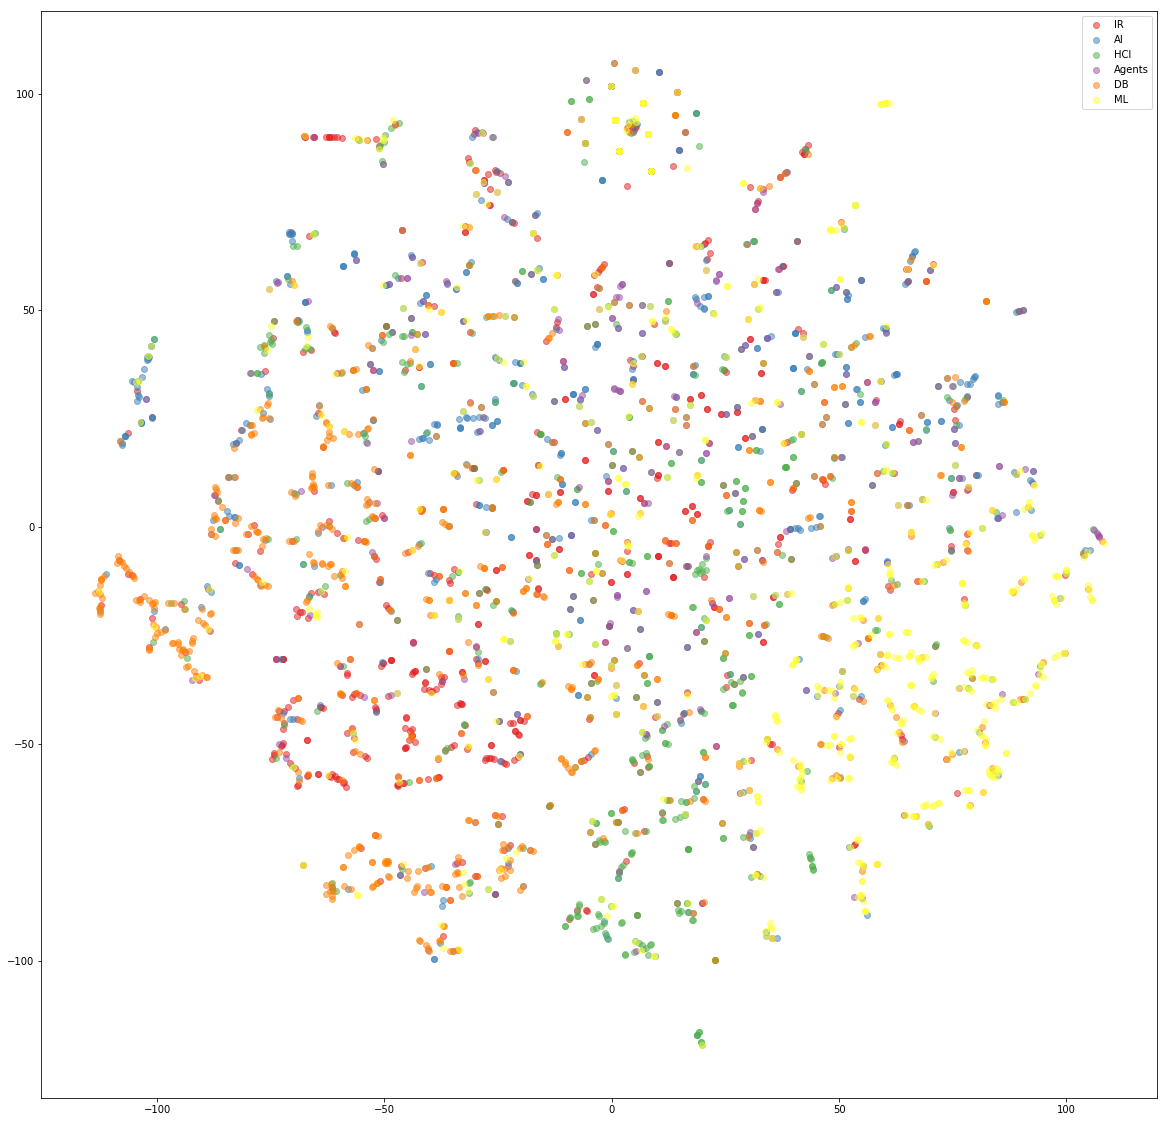

In [36]:
plt.figure(figsize = (20, 20))
colors = plt.cm.get_cmap('Set1').colors

for i, label in enumerate(plot_df['y_label'].unique()):

    colors      = plt.cm.get_cmap('Set1').colors
    plot_df_sub = plot_df.loc[plot_df['y_label'] == label]
    
    plt.scatter(plot_df_sub['x0'], plot_df_sub['x1'], c = matplotlib.colors.to_hex(colors[i]),
                alpha = 0.5, cmap = cm.hsv, label = label)

plt.legend()

In [18]:
colors

((0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6))

In [31]:
set(test_idx_range_full) - set(test_idx_range)

{2407,
 2489,
 2553,
 2682,
 2781,
 2953,
 3042,
 3063,
 3212,
 3214,
 3250,
 3292,
 3305,
 3306,
 3309}

In [25]:
len(test_idx_range_full)

1015

In [27]:
tx.shape

(1015, 3703)

In [50]:
tx

<1015x3703 sparse matrix of type '<class 'numpy.float64'>'
	with 31992 stored elements in LInked List format>

In [44]:
x

<120x3703 sparse matrix of type '<class 'numpy.float32'>'
	with 3778 stored elements in Compressed Sparse Row format>

In [59]:
ty.shape

(1015, 6)

In [60]:
y.shape

(120, 6)